In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

# New imports
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path
from sklearn.metrics import mean_squared_error

# Disable the sklearn warning caused by the code snipped at page 274 in the book
import warnings
warnings.filterwarnings("ignore")

## Forward Selection

In [2]:
Hitters = load_data('Hitters')
display(Hitters.head())
display(Hitters.shape)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


(322, 20)

In [3]:
print(np.isnan(Hitters['Salary']).sum())
Hitters = Hitters.dropna()
Hitters.shape

59


(263, 20)

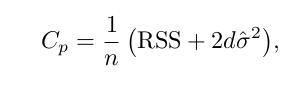

The Cp will be used to choose the best model using forward selection.

In [4]:
def nCp(sigma2, estimator, X, Y):
    'Negative Cp statistic'
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -((1/n) * (RSS + 2*sigma2*p))

In [5]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale

In [6]:
neg_Cp = partial(nCp, sigma2)
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [7]:
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

## Choosing among the models Using the validation set approach and cross-validation

In [8]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')

full_path = sklearn_selection_path(OLS, strategy)

In [9]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

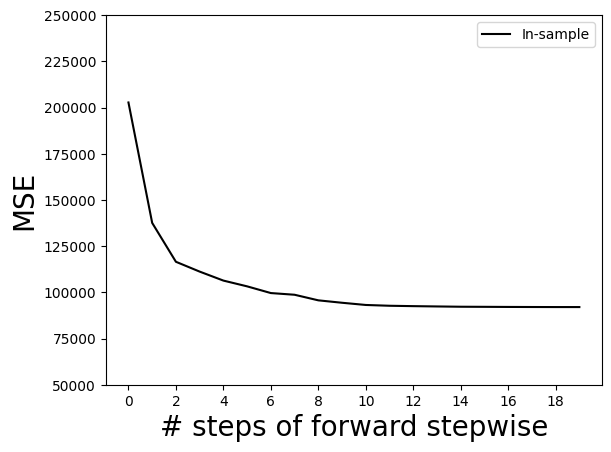

In [10]:
mse_fig = plt.figure()
ax = mse_fig.add_subplot()
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k',
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

In [11]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

Relevant from book: The prediction matrix Yhat_cv is the same shape as Yhat_in; the difference
is that the predictions in each row, corresponding to a particular sample
index, were made from models fit on a training fold that did not include
that row.

In [12]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

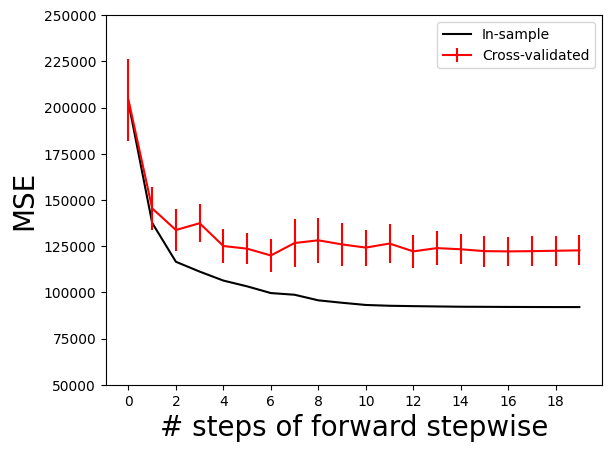

In [13]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r')
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [14]:
train_test_split = skm.ShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=0)
train_test_split

ShuffleSplit(n_splits=1, random_state=0, test_size=0.8, train_size=0.2)

In [15]:
shuffle = skm.ShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=0)
shuffle.split

<bound method BaseShuffleSplit.split of ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=0.8)>

In [16]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    validation_mse = errors.mean(0)

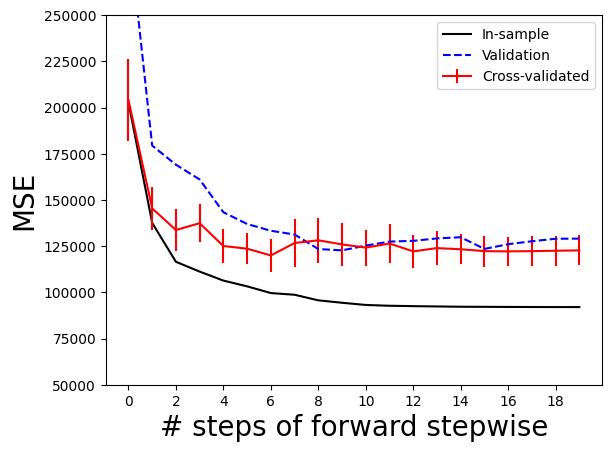

In [17]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--',
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

## Best subset selection

In [18]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

path = fit_path(X,
                Y,
                max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


# Ridge Regression and the Lasso

In [19]:
# Standardizing with Z scores
Xs = X - X.mean(0)[None, :]
X_scale = X.std(0)
Xs = Xs / X_scale[None, :]

lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array

array([[ 8.00310363e-04,  1.00986867e-03,  1.27429625e-03, ...,
        -2.90923382e+02, -2.90958537e+02, -2.90986528e+02],
       [ 8.89318672e-04,  1.12218451e-03,  1.41602291e-03, ...,
         3.37260446e+02,  3.37377455e+02,  3.37470648e+02],
       [ 6.95410715e-04,  8.77500619e-04,  1.10726717e-03, ...,
         3.75180641e+01,  3.75871222e+01,  3.76420770e+01],
       ...,
       [ 5.15666738e-05,  6.50694021e-05,  8.21076995e-05, ...,
         5.36633570e+01,  5.36777586e+01,  5.36891521e+01],
       [-1.09496252e-05, -1.38170424e-05, -1.74354208e-05, ...,
        -2.21910710e+01, -2.21848930e+01, -2.21799639e+01],
       [-5.74274914e-06, -7.24531429e-06, -9.14061794e-06, ...,
        -1.23832054e+01, -1.23761905e+01, -1.23705867e+01]])

In [20]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


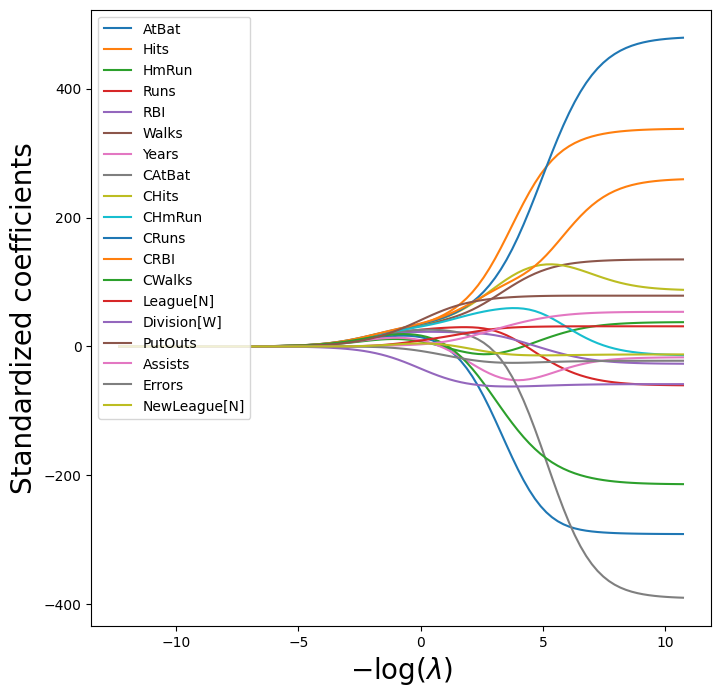

In [21]:
path_fig = plt.figure(figsize=(8, 8))
ax = path_fig.add_subplot()
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

In [22]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [23]:
beta_hat

AtBat           5.433750
Hits            6.223582
HmRun           4.585498
Runs            5.880855
RBI             6.195921
Walks           6.277975
Years           5.299767
CAtBat          7.147501
CHits           7.539495
CHmRun          7.182344
CRuns           7.728649
CRBI            7.790702
CWalks          6.592901
League[N]       0.042445
Division[W]    -3.107159
PutOuts         4.605263
Assists         0.378371
Errors         -0.135196
NewLeague[N]    0.150323
Name: -3.240065292879872, dtype: float64

In [24]:
np.linalg.norm(beta_hat)

24.17061720144378

In [25]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725912)

In [26]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [27]:
np.linalg.norm(ridge.coef_)

160.42371017725904

### Estimating Test Error of Ridge Regression

In [28]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([134214.00419204])

In [29]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([231788.32155285])

In [30]:
param_grid = {'ridge__alpha':lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
display(grid.best_params_['ridge__alpha'])
display(grid.best_estimator_)

0.005899006046740856

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [31]:
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
display(grid.best_params_['ridge__alpha'])
display(grid.best_estimator_)

0.01185247763144249

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

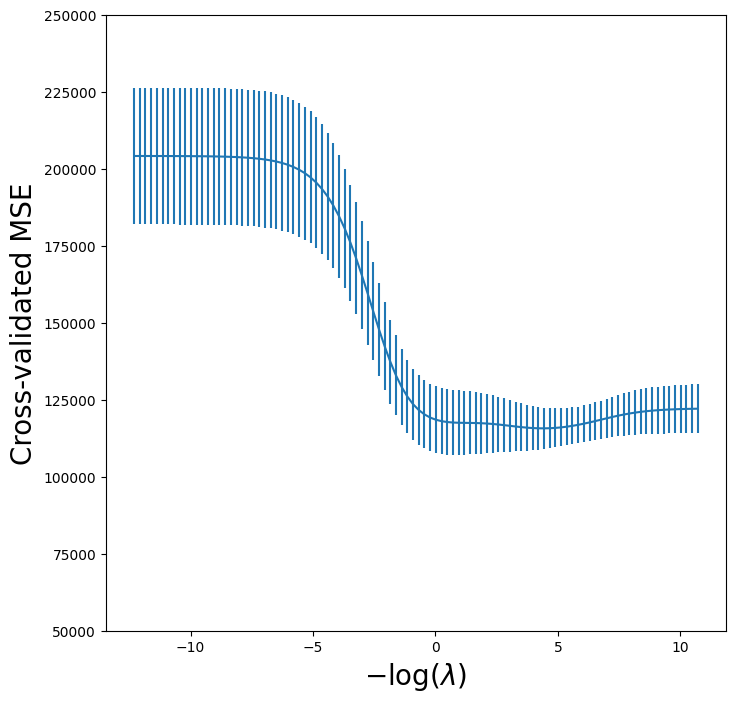

In [32]:
ridge_fig = plt.figure(figsize=(8,8))
ax = ridge_fig.add_subplot()
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000, 250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

Text(0, 0.5, 'Cross-validated $R^2$')

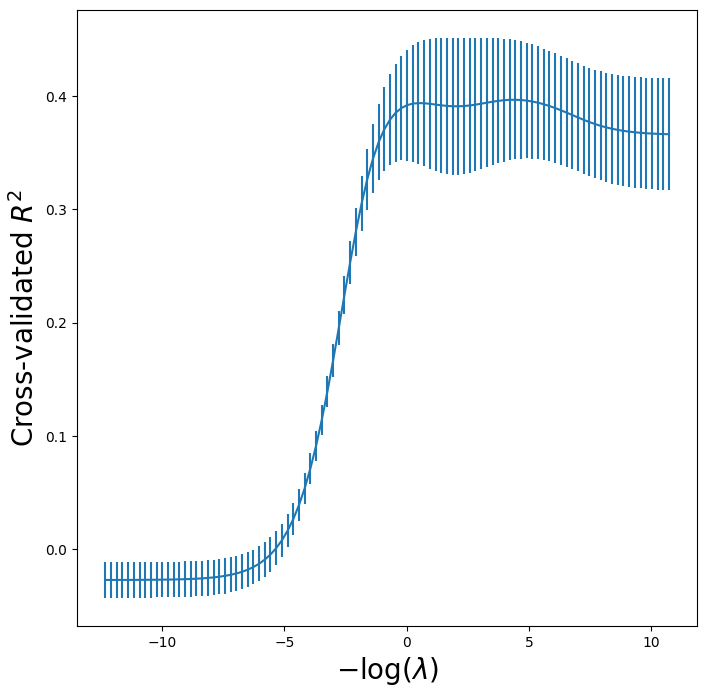

In [33]:
grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)

r2_fig = plt.figure(figsize=(8,8))
ax = r2_fig.add_subplot()
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20)

### Fast Cross-Validation for Solution Paths

In [34]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

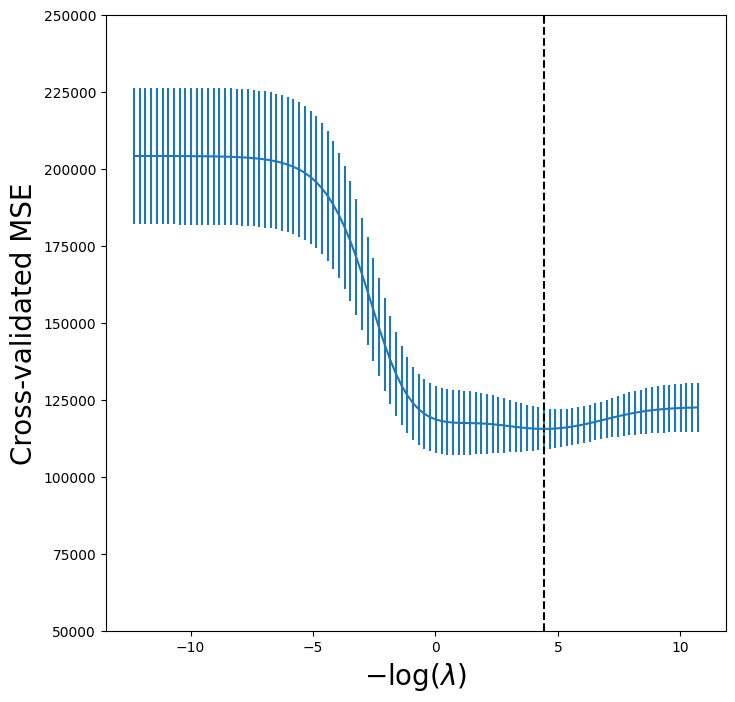

In [35]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig = plt.figure(figsize=(8, 8))
ax = ridgeCV_fig.add_subplot()
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50000, 250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
            

In [36]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987729

In [37]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

### Evaluating Test Error of Cross-Validated Ridge

In [38]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])

In [39]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']

array([132393.84003227])

### The Lasso

In [40]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [41]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                     Y,
                                     l1_ratio=1,
                                     n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

Text(0, 0.5, 'Standardized coefficients')

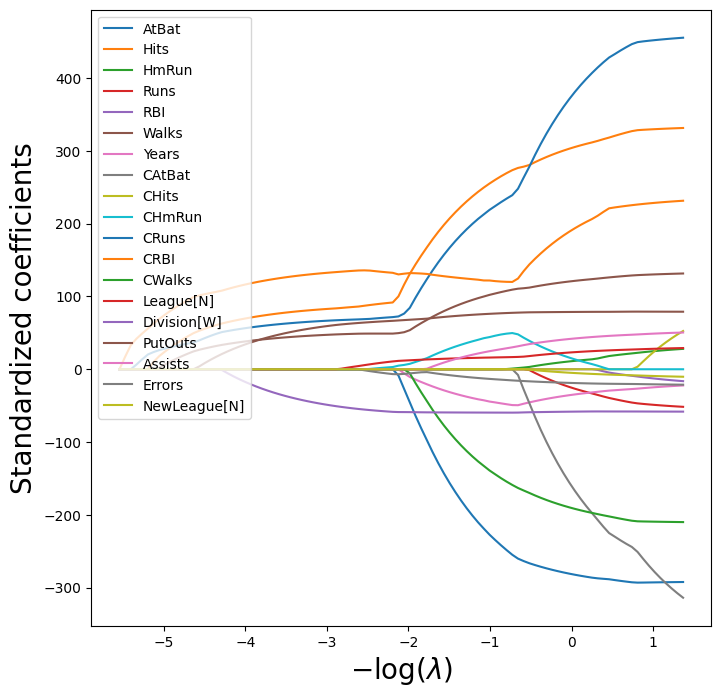

In [42]:
path_fig = plt.figure(figsize=(8, 8))
ax = path_fig.add_subplot()
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)

In [43]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253653

Text(0, 0.5, 'Cross-validated MSE')

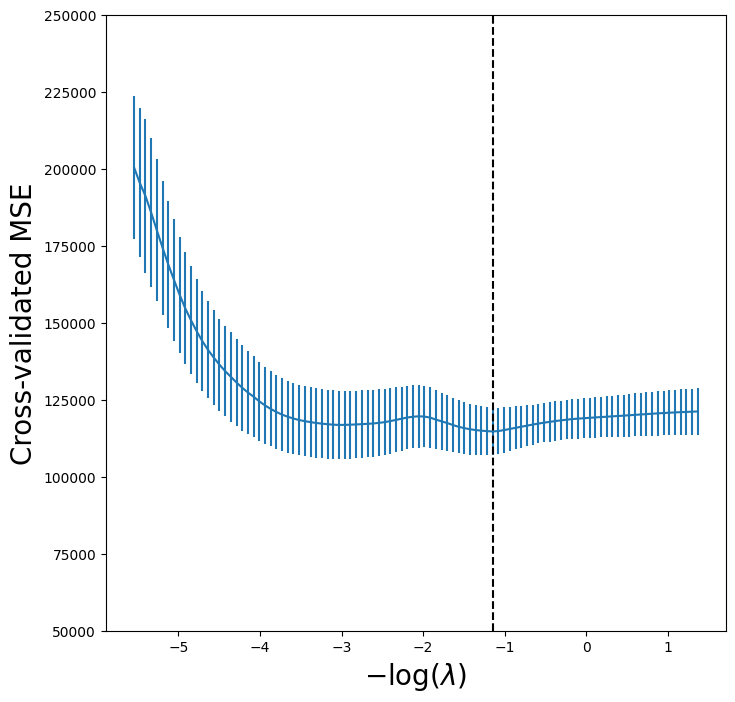

In [44]:
lassoCV_fig = plt.figure(figsize=(8, 8))
ax = lassoCV_fig.add_subplot()
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000, 250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [45]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

In [46]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])

In [47]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']

array([133473.13684813])

Compared to the Ridge test MSE of array([132393.84003227])

## PCR and PLS Regression

### Principal Components Regression

In [48]:
Hitters = load_data('Hitters')
Hitters = Hitters.dropna()

In [49]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [50]:
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

In [51]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

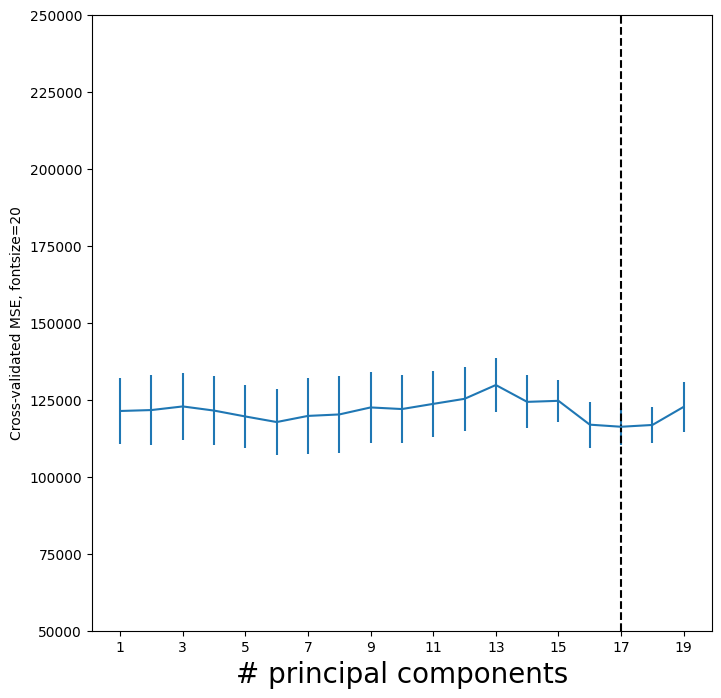

In [52]:
pcr_fig = plt.figure(figsize=(8, 8))
ax = pcr_fig.add_subplot()
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE, fontsize=20')
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000, 250000])
ax.axvline((-grid.cv_results_['mean_test_score']).argmin()+1, c='k', ls='--')

In [53]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

204139.30692994667

In [54]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

### Partial Least Squares

In [55]:
pls = PLSRegression(n_components=2,
                    scale=True)
pls.fit(X, Y)

PLSRegression()

In [56]:
param_grid = {'n_components': range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

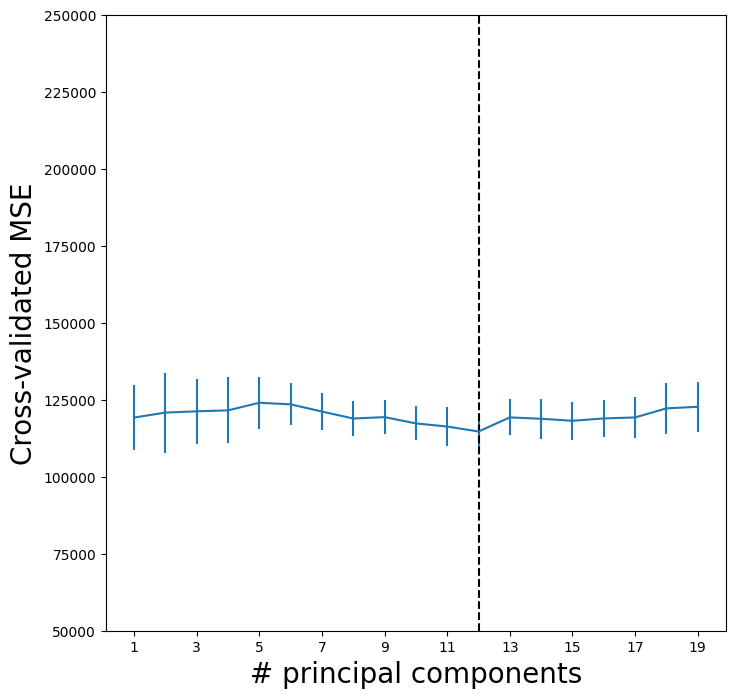

In [57]:
pls_fig = plt.figure(figsize=(8, 8))
ax = pls_fig.add_subplot()
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000, 250000])
ax.axvline((-grid.cv_results_['mean_test_score']).argmin()+1, c='k', ls='--')

# Exercies

## Conceptual

1. We perform best subset, forward stepwise, and backward stepwise selection on a single data set. For each approach, we obtain p+1 models, containing 0,1,2....,p predictors. Explain your answer:

   (a) Which of the three models with k predictors has the smallest training RSS?
   Answer is best subset since it performs a model for every single permutation of variables and it chooses them by the RSS metric.

   (b) Which of the three models with k predictors has the smallest test RSS?
   Answer is best subset since, with cross validation, we can easly find the best subset of variables that best fit the model.

    another answer from the internet: Hard to say with the given information. Best subset may overfit if n is relativly small compared to p. Also the other two methods may pick a model that performs better on test set by luck.

   (c) True or False:

   i. The predictors in the k-variable model identified by forward stepwise are a subset of the predictors in the (k+1)-variable model identified by forward stepwise selection.
    True, they will be the first k-variables of the k+1 variable model.

   ii. The predictors in the k-variable model identified by backward stepwise are a subset of the predictors in the (k+1)-variable model identified by backward stepwise selection.
   Its true because k+1 variable model includes all of the variables and invariably the k-variable model will include a subset of the k+1 variable model.

   iii. The predictors in the k-variable model identified by backward stepwise are a subset of the predictors in the (k+1) variable model identified by forward stepwise selection.
   False. Lets say we fit a model with 5 predictors and we want to know if the 4 variable model found by forward selection consists of 4 variables that are a subset of the 4 variable model found by backward selection. We cant know for sure if the 5th variable that is going to be removed from backwise is going to be the variable missing from the forward.

   iv. The predictors in the k-variable model identified by forward stepwise are a subset of the predictors in the (k+1) variable model identified by backward stepwise selection.
   Same answer as iii.

   v. The predictors in the k-variable model identified by best subset are a subset of the predictors in the (k+1) variable model identified by best subset selection.
   False.

2. For parts (a) through (c), indicate which of i, through iv, is correct. Justify your answer.

   (a) The lasso, relative to least squares, is:

   i. More flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.
    The lasso is used to shrink the coefficients, hence has less flexibility than least squares. Answer is False.

   ii. More flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.
    It is true that its goal is to decrease the variance while not increasing the bias. But the answer overall is False.

   iii. Less flexible and hence will give improved precition accuracy when its increase in bias is less than its decrease in variance.
   True.

   iv. Less flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.
   False.

   (b) Ridge, relative to least squares, is:

   Same answers as (a). Even though the ridge regression doesnt shrink the coefficients to 0, it still holds the same characteristics that the lasso has relative to least squares.

   (c) Non-linear methods, relative to least squares, are:

   (ii) More flexible and hence will give improved prediction accuracy when their increase in variance is less than its decrease in bias.

   The non-linear methods are way more flexible relative to least squares and hence tend to have higher variance. If its increase in variance is less than its decrease in bias then the model tends to perform better. Answer to this is false and its true to (ii).

4. Suppose we estimate the regression coefficients in a linear regression model by minimizing:
   ![image.png](attachment:1e68e4cd-893a-4129-b941-c34126052313.png)

   for a particular value of s. For parts (a) through (e), indicate which of i through v is correct. Justify your answer.

   (a) As we increase s from 0, the training RSS will:

   i. Increase initially, and then eventually start decreasing in an inverted U shape.
   False. Increasing s from 0 will lead to a better training RSS.

   ii. Decrease initially, and then eventually start increasing in a U shape.
   False. On the training data, the RSS will keep decreasing no metter what.

   iii. Steadily increase.
   False.

   iv. Steadily decrease.
   True.

   v. Remain constant.
   False.

   (b) As we increase s from 0, the test RSS will:
   
   ii. True. It does increase initially because the flexibility will increase, the variance will decrease more than bias increases. But the higher the s-value after a certain point, the higher the test error is going to be.

   (c) As we increase s from 0, the variance will:
    
   iii. True.

   "With increased flexibility variance always increases."

   (d) As we increase s from 0, the squared bias will:

   iv. True

   "With increased flexibility bias always decreases."

   (e) As we increase s from 0, the irreducible error will:

   v. Remain constant.

   
relevant:

![image.png](attachment:ebbc71dc-3213-4485-a07f-70a62ee9f13a.png)

4. Suppose we estimate the regression coefficients in a linear regression model by minimizing
   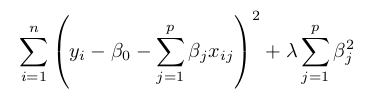

for a particular value of lambda. For parts (a) through (c), indicate which of i through v is correct. Justify your answer

(a) As we increase lambda from 0, the training RSS will: Steadily increase. As the flexibility decreases, the training RSS will increase.

(b) Decrease initially and then eventually start increasing in a U shape. That is because if we find the right value for lambda the ridge model should in theory be better than least squares.

(c) As the flexibility decreases the variance steadily decreases.

(d) As the flexbility decreases, the bias squared increases.

(e) The irreducible error remains constant.

5. It is well known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting:

   Suppose that n=2, p=2, x11=x12, x21=x22. Furthermore, suppose that y1 + y2 = 0 and x11 + x21 = 0 and x12 + x22 = 0 so that the estimate for the intercept in a least squares, ridge regression or lasso model is zero B0 = 0.

   (a) Write yout the ridge regression optimization problem in this setting.

   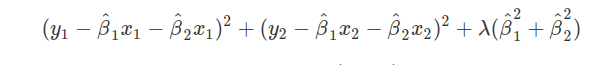

   (b) Argue that in this setting, the ridge coefficient estimate satisfy B1^ = B2^

   (c) Write out the lasso optimization problem in this setting.

   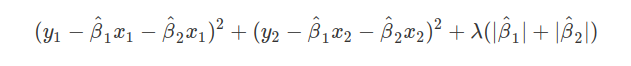

   (d) Argue that in this setting, the lasso coefficients B1 and B2 are not unique - in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

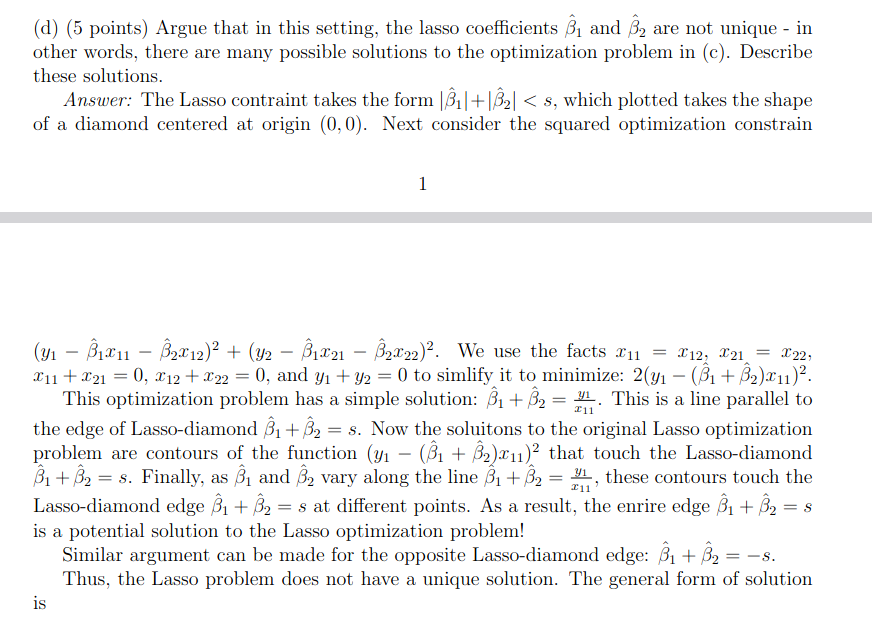

6. We will now explore 6.12 and 6.13 furter.

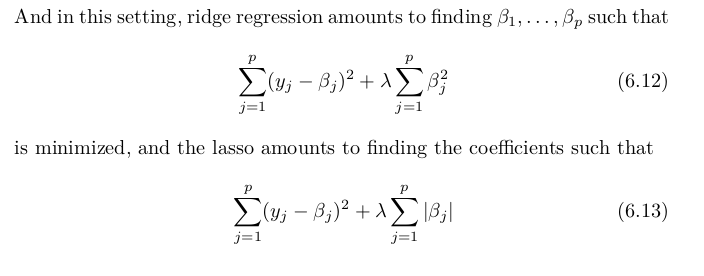

(a) Consider 6.12 with p = 1. For some choice of y1 and lambda > 0, plot 6.12 as a function of B1. Your plot should confirm that 6.12 is solved by 6.14.

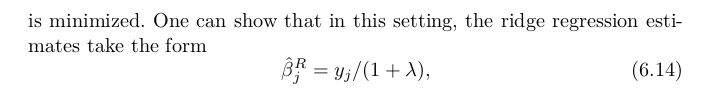

Text(0.5, 0, 'beta')

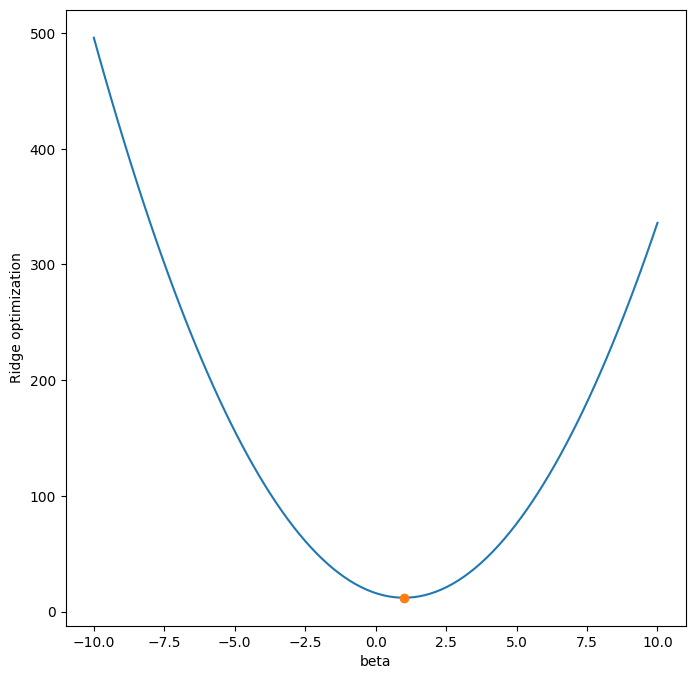

In [58]:
alpha = 3
y = 4
betas = np.linspace(-10, 10, 100)
ridge = (y-betas)**2 + alpha*betas**2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.plot(betas, ridge)

beta_r = y/(1+alpha)

ax.plot(beta_r,
        (y-beta_r)**2 + alpha*beta_r**2,
        'o')


ax.set_ylabel('Ridge optimization')
ax.set_xlabel('beta')

(b) Consider 6.13 with p = 1. For some choice of y and lambda > 0, plot 6.13 as a function of B1. Your plot should confirm that 6.13 is solved by 6.15.

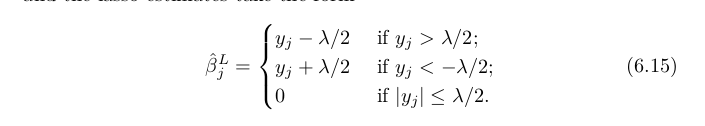

Text(0.5, 0, 'beta')

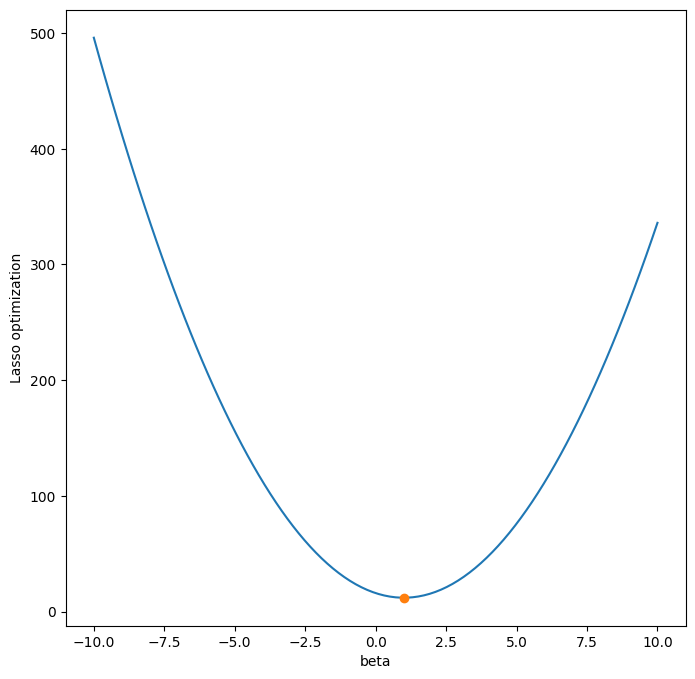

In [59]:
lasso = (y-betas)**2 + alpha*np.abs(betas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.plot(betas, ridge)

beta_l = y/(1+alpha)

ax.plot(beta_r,
        (y-beta_l)**2 + alpha*np.abs(beta_l),
        'o')


ax.set_ylabel('Lasso optimization')
ax.set_xlabel('beta')

7. We will now derive the Bayesian connection to the lasso and ridge regression discussed in Section 6.2.2.
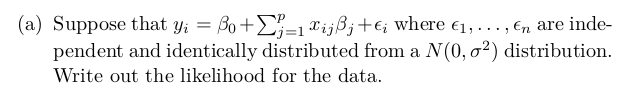

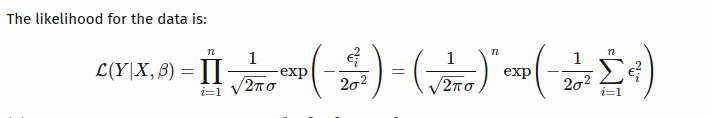
   

# Applied

8. In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

   (a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector e of length n = 100.

In [60]:
rng = np.random.default_rng(16)
n = 100

X = rng.normal(size=n)
e = rng.normal(size=n)
betas = [17, 3, .8, -2]

    (b) Generate a response vector Y of length n=100 according to the model

    Y = B0 + B1X + B2X^2 + B3X^3 + e

    where the betas are constants of your choice.

In [61]:
Y = betas[0] + betas[1]*X + \
    betas[2]*X**2 + \
    betas[3]*X**3 + e

    (c) Use forward stepwise selection in order to select a model containing the predictors X...X^2. What is the model obtained according to Cp? Rport the coefficients of the model obtained.

In [62]:
X_poly = np.power.outer(X, [range(1, 11)])[:, 0]
X_poly = pd.DataFrame(data=X_poly)
X_poly.columns = [f'X**{n}' for n in range(1, 11)]

In [63]:
design = MS(X_poly.columns).fit(X_poly)
X_features = design.transform(X_poly)
sigma2 = OLS(Y, X_features).fit().scale

In [64]:
neg_Cp = partial(nCp, sigma2)
strategy = Stepwise.first_peak(design,
                               direction=['forward'],
                               max_terms=len(design.terms))

sim_MSE = sklearn_selected(OLS,
                               strategy)
sim_MSE.fit(X_poly, Y)
sim_MSE.selected_state_

('X**1',
 'X**10',
 'X**2',
 'X**3',
 'X**4',
 'X**5',
 'X**6',
 'X**7',
 'X**8',
 'X**9')

In [65]:
sim_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
sim_Cp.fit(X_poly, Y)
sim_Cp.selected_state_

('X**1', 'X**2', 'X**3')

In [66]:
## LETS TRY BEST SUBSET!
D = X_features.drop('intercept', axis=1)
X_D = np.asarray(D)

path = fit_path(X_D,
                Y,
                max_nonzeros=X_D.shape[1])

path[2]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  5
Iteration: 4. Number of non-zeros:  10


{'B': array([ 1.64051397e+00,  9.12002810e-01, -1.06553712e+00,  0.00000000e+00,
        -1.19356018e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.67662838e-04]),
 'B0': 16.900230780747272,
 'lambda_0': 0.0006585297682445346,
 'M': 1.078285239470411,
 'Time_exceeded': False}

(d)

In [67]:
X_poly = np.power.outer(X, [range(1, 11)])[:, 0]
X_poly = pd.DataFrame(data=X_poly)
X_poly.columns = [f'X**{n}' for n in range(1, 11)]

In [68]:
design = MS(X_poly.columns).fit(X_poly)
X_features = design.transform(X_poly)
sigma2 = OLS(Y, X_features).fit().scale

In [69]:
neg_Cp = partial(nCp, sigma2)
strategy = Stepwise.first_peak(design,
                               direction=['backward'],
                               max_terms=len(design.terms))

sim_MSE = sklearn_selected(OLS, strategy)
sim_MSE.fit(X_poly, Y)
sim_MSE.selected_state_

('X**1',
 'X**10',
 'X**2',
 'X**3',
 'X**4',
 'X**5',
 'X**6',
 'X**7',
 'X**8',
 'X**9')

In [70]:
sim_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
sim_Cp.fit(X_poly, Y)
sim_Cp.selected_state_

('X**1', 'X**2', 'X**3')

(e) Now fit a lasso model to the simulated data, again using X, X^2... X^10 as predictors. Use cross-validation to select the optimal value of lambda. Create plots of the cross-validation error as a function of lambda. Report the resulting coefficient estimates and discuss the results obtained.

We are going to fit a ridge model too... we are first fitting a ridge model.

In [71]:
lambdas = 10**np.linspace(8, -2, Y.shape[0]) / Y.std()
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X_poly, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.03832777e+07, 1.61533990e+07, 1.28012924e+07, 1.01448053e+07,
       8.03958473e+06, 6.37123341e+06, 5.04909351e+06, 4.00132026e+06,
       3.17097788e+06, 2.51294574e+06, 1.99146652e+06, 1.57820316e+06,
       1.25069902e+06, 9.91157582e+05, 7.85475433e+05, 6.22475848e+05,
       4.93301464e+05, 3.90932974e+05,...
       1.69225552e-01, 1.34108356e-01, 1.06278579e-01, 8.42239560e-02,
       6.67460448e-02, 5.28950990e-02, 4.19184614e-02, 3.32196638e-02,
       2.63260154e-02, 2.08629170e-02, 1.65335049e-02, 1.31025199e-02,
       1.03835230e-02, 8.22876437e-03, 6.52115504e-03, 5.16790385e-03,
       4.09547542e-03, 3.24559423e-03, 2.57207792e-03, 2.03832777e-03]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

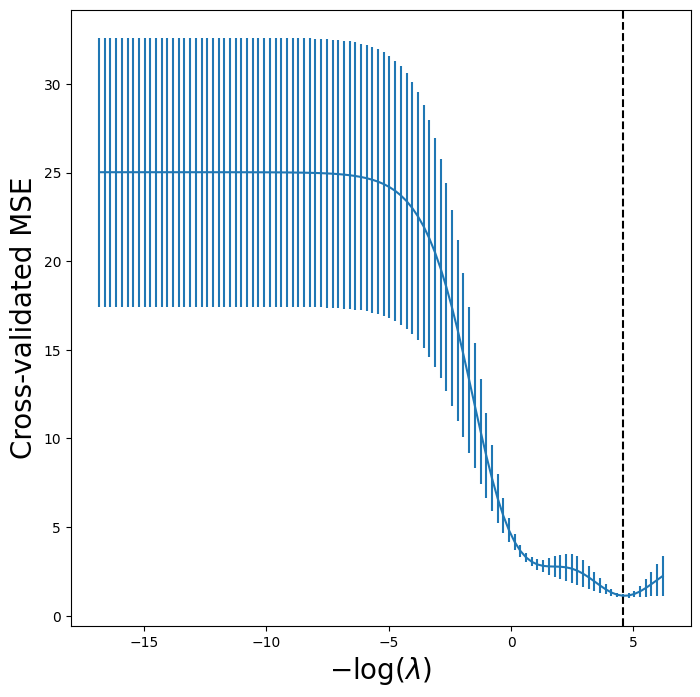

In [72]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig = plt.figure(figsize=(8, 8))
ax = ridgeCV_fig.add_subplot()
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [73]:
tuned_ridge.coef_

array([ 2.05902661,  0.93609445, -4.25178091,  0.56431911, -2.21139982,
        0.0307619 , -0.34120849, -0.19133215,  0.69417778, -0.23591355])

In [74]:
lassoCV = skl.ElasticNetCV(n_alphas=Y.shape[0],
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_poly, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=1))])

Text(0, 0.5, 'Cross-validated MSE')

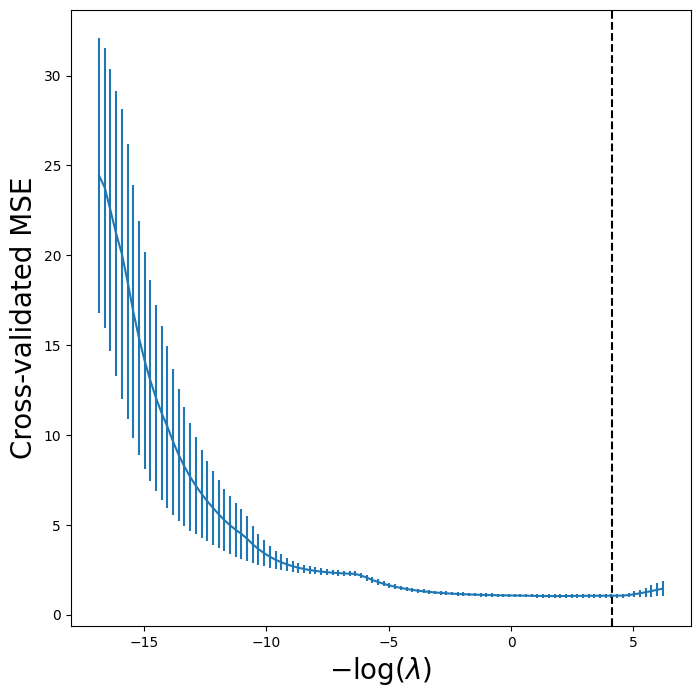

In [75]:
tuned_lasso = pipeCV.named_steps['lasso']
lassoCV_fig = plt.figure(figsize=(8, 8))
ax = lassoCV_fig.add_subplot()
ax.errorbar(-np.log(lambdas),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [76]:
tuned_lasso.coef_

array([ 2.73471671,  1.23509449, -6.59513131,  0.        , -0.10147707,
       -0.        , -0.        , -0.        , -0.        , -0.07297115])

Using cross validation to select the best lambda value for a lasso model, we find out that the intercept, x1, x2, x3, x4, x9 and x10 are nonzeros.

    (f) Now generate a response vector Y according to the model

    Y = B0 + B7X^7 + eps

    and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [77]:
Y = betas[0] + 7*X**7 + e

In [78]:
design = MS(X_poly.columns).fit(X_poly)
X_features = design.transform(X_poly)
sigma2 = OLS(Y, X_features).fit().scale

In [79]:
neg_Cp = partial(nCp, sigma2)
strategy = Stepwise.first_peak(design,
                               direction=['forward'],
                               max_terms=len(design.terms))

sim_MSE = sklearn_selected(OLS, strategy)
sim_MSE.fit(X_poly, Y)

sim_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
sim_Cp.fit(X_poly, Y)
sim_Cp.selected_state_

('X**7',)

In [80]:
lassoCV = skl.ElasticNetCV(n_alphas=Y.shape[0],
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_poly, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.6551272375480585

In [81]:
lambdas, soln_array = skl.Lasso.path(X_poly,
                                     Y,
                                     l1_ratio=1,
                                     n_alphas=Y.shape[0])[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(tuned_lasso.alphas_))

Text(0, 0.5, 'Standardized coefficients')

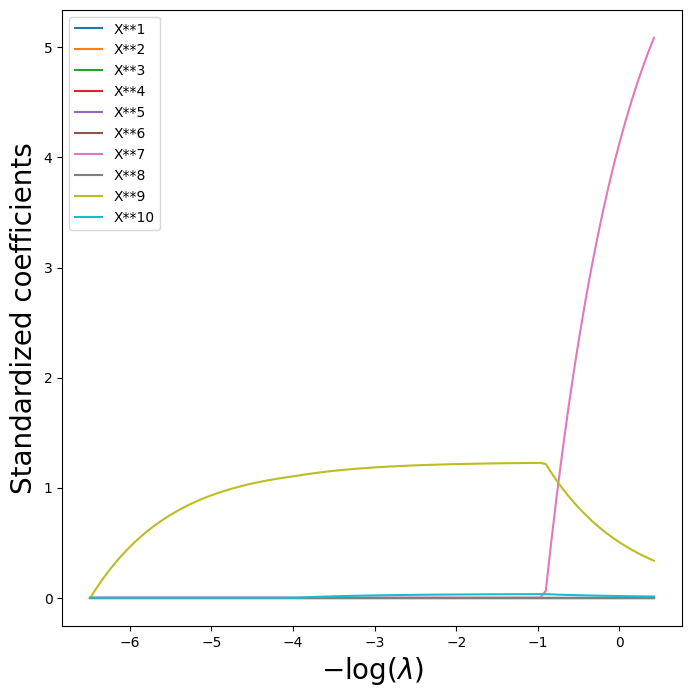

In [82]:
path_fig = plt.figure(figsize=(8, 8))
ax = path_fig.add_subplot()
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)

Text(0, 0.5, 'Cross-validated MSE')

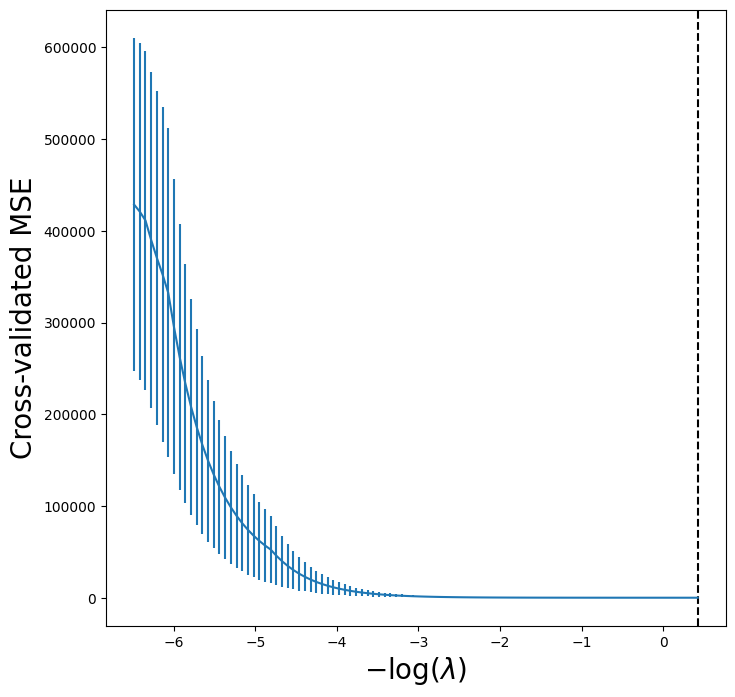

In [83]:
lassoCV_fig = plt.figure(figsize=(8, 8))
ax = lassoCV_fig.add_subplot()
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [84]:
-np.log(tuned_lasso.alpha_)

0.42292580641353716

In [85]:
soln_path.loc[-np.log(tuned_lasso.alpha_)]

X**1     0.000000
X**2     0.000000
X**3     0.000000
X**4     0.000000
X**5     0.000000
X**6    -0.000000
X**7     5.087898
X**8    -0.000000
X**9     0.336462
X**10    0.011232
Name: 0.42292580641353716, dtype: float64

Seems like non-zeros are X^7, X^9 and X^10.

9. In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [86]:
College = load_data('College')

# Getting dummies out of the private variable
College['Private'] = np.where(College['Private'] == 'Yes', 1, 0)
College = sm.add_constant(College)

(a) Split the data set into a training set and a test set.

In [87]:
# lets use the shufflesplit method, for fun!
for train_idx, test_idx in \
    skm.ShuffleSplit(n_splits=1, test_size=0.1, random_state=0).split(College):
        Train = College.iloc[train_idx]
        Test = College.iloc[test_idx]

X_train = Train.drop(columns='Apps')
Y_train = Train['Apps']
X_test = Test.drop(columns='Apps')
Y_test = Test['Apps']

(b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [88]:
model = OLS(Y_train,
            X_train).fit()
Y_pred = model.predict(X_test)
MSE_linear = np.mean(
    np.square(Y_test - Y_pred))

(c) Fit a ridge regression model on the training set, with lambda chosen by cross-validation. Report the test error obtained.

In [89]:
lambdas = 10**np.linspace(8, -2, Y_train.shape[0]) / Y_train.std()
ridge = skl.ElasticNet(alpha=lambdas, l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha':lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
MSE_ridge = np.mean(
    np.square(Y_test - Y_pred))

In [90]:
lasso = skl.ElasticNetCV(n_alphas=Y_train.shape[0],
                         l1_ratio=1,
                         cv=kfold)
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipe.fit(X_train, Y_train)

Y_pred = pipe.predict(X_test)
MSE_lasso = np.mean(
    np.square(Y_test - Y_pred))

Lets try with the method used in the Lab... lets see if the results are different.

In [91]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.20,
                               random_state=0)
lasso = skl.ElasticNetCV(n_alphas=Y_train.shape[0],
                         l1_ratio=1,
                         cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lasso)])

results = skm.cross_validate(pipeCV,
                             College.drop(columns='Apps'),
                             College['Apps'],
                             cv=outer_valid,
                             scoring='r2')
-results['test_score']

array([-0.87403939])

Identical results... mostly.

(e) Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [92]:
pca = PCA()
linreg = skl.LinearRegression()

pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])

param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, Y_train)

Y_pred = grid.predict(X_test)
MSE_pcr = np.mean(
    np.square(Y_test - Y_pred))

(f) Fit a PLS model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [93]:
pls = PLSRegression(scale=True)
param_grid = {'pls__n_components': range(1,19)}
pipe = Pipeline([('scaler', scaler),
                 ('pls', pls)])
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, Y_train)

Y_pred = grid.predict(X_test)[:, 0]
MSE_pls = np.mean(
    np.square(Y_test - Y_pred))

In [94]:
errors = {
    'Linear': MSE_linear,
    'Ridge': MSE_ridge,
    'Lasso': MSE_lasso,
    'PCR': MSE_pcr,
    'PLS': MSE_pls,
}

print(errors)

{'Linear': 716836.5954065855, 'Ridge': 716812.8741472334, 'Lasso': 652163.7854246652, 'PCR': 716836.5954063551, 'PLS': 716836.5954063543}


It seems like the lasso performs best.

Next time try using R2 to compare test and pred.

10. We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

    (a) Generate a data set with p=20 features, n=1000 observations and an associated quantitative response vector generated according to the model
    Y = XB + e,

    where B has some elements that are exactly equal to zero.

    (b) Split your data set into a training set containing 100 observations and a test set containing 900 observations.

In [290]:
# Generate X matrix
X = np.random.randn(1000, 20)

# Generate b vector with some zeros
b = np.random.randn(20)
b[2] = b[3] = b[8] = b[10] = b[12] = b[13] = b[6] = b[18] = 0

# Generate eps vector
eps = np.random.randn(1000)

# Calculate y
y = np.dot(X, b) + eps

(X_train, X_test,
 Y_train, Y_test) = skm.train_test_split(X, y, test_size=0.9, random_state=0)

In [291]:
X_train.shape

(100, 20)

In [292]:
Y_train.shape

(100,)

(c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

(idk how to do this, i will just plot the MSE of each iteration of l0bnb.fit_path instead...)

In [293]:
path = fit_path(X_train,
                Y_train)
best_subset = np.where(path[-1]['B'] != 0)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  4
Iteration: 5. Number of non-zeros:  4
Iteration: 6. Number of non-zeros:  4
Iteration: 7. Number of non-zeros:  5
Iteration: 8. Number of non-zeros:  5
Iteration: 9. Number of non-zeros:  5
Iteration: 10. Number of non-zeros:  7
Iteration: 11. Number of non-zeros:  7
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  10


In [294]:
X_train_subset = X_train[:, best_subset][:, 0]
X_test_subset = X_test[:, best_subset][:, 0]
model = OLS(Y_train,
            X_train_subset).fit()
Y_pred = model.predict(X_train_subset)
MSE = np.mean((Y_train - Y_pred)**2)

In [295]:
MSE = np.zeros(len(path))

for idx, iter in enumerate(path):
    subset = np.where(iter['B'] != 0)
    X_train_subset = X_train[:, subset][:, 0]
    X_test_subset = X_test[:, subset][:, 0]
    model = OLS(Y_train,
                X_train_subset).fit()
    Y_pred = model.predict(X_train_subset)
    MSE[idx] = np.mean((Y_train - Y_pred)**2)


Text(0, 0.5, 'Training MSE')

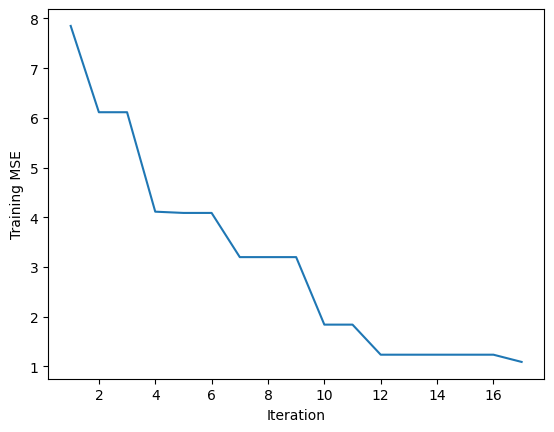

In [296]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(1, len(path)+1), MSE)
ax.set_xlabel('Iteration')
ax.set_ylabel('Training MSE')

(d) Plot the test set MSE associated with the best model of each size.

In [297]:
MSE = np.zeros(len(path))

for idx, iter in enumerate(path):
    subset = np.where(iter['B'] != 0)
    X_train_subset = X_train[:, subset][:, 0]
    X_test_subset = X_test[:, subset][:, 0]
    model = OLS(Y_train,
                X_train_subset).fit()
    Y_pred = model.predict(X_test_subset)
    MSE[idx] = np.mean((Y_test - Y_pred)**2)

Text(0, 0.5, 'Test MSE')

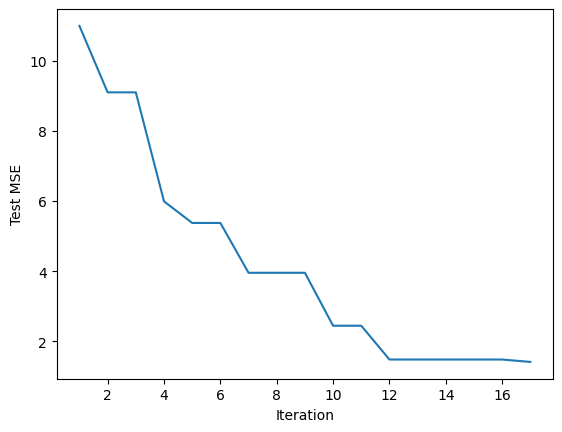

In [298]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(1, len(path)+1), MSE)
ax.set_xlabel('Iteration')
ax.set_ylabel('Test MSE')

In [117]:
import itertools as it
from sklearn.linear_model import LinearRegression

def select_subset_sizeK(X_, y_, k):
    model = LinearRegression()
    best_score = 0.0
    M_k = []
    for combo in it.combinations(range(X_.shape[1]), k):
        X = X_[:, list(combo)]
        model.fit(X, y_)
        s = model.score(X, y_)
        if s > best_score:
            M_k = list(combo)
            best_score = s
    return M_k

def subset_selection(X_, y_):
    # Fit model with intercept only (Null model)
    train_MSE = {}
    model_cols = {}
    y_pred = np.mean(y_)
    train_MSE[0] = np.sum((y_ - y_pred)**2) / len(y_)
    for s in range(1, X_.shape[1]):
        cols = select_subset_sizeK(X_, y_, s)
        X = X_[:, cols]
        model = LinearRegression()
        model.fit(X, y_)
        y_pred = model.predict(X)
        train_MSE[s] = mean_squared_error(y_pred, y_)
        model_cols[s] = cols
    return (model_cols, train_MSE)

# t = subset_selection(X_train, Y_train)
# models = t[0]
# train_MSE = t[1]

# fig = plt.figure(figsize=(15, 8))

# lists = sorted(train_MSE.items()) # sorted by key, return a list of tuples
# x, y = zip(*lists) # unpack a list of pairs into two tuples
# ax = fig.add_subplot(121)
# plt.plot(x, y, color='r')
# plt.grid()
# ax.set_xlabel('Model Size')
# ax.set_ylabel('Training MSE')
# ax.set_title('Training MSE vs Model Size')

# test_MSE = {}
# for size, cols in models.items():
#     if size == 0:
#         test_MSE[size] = np.sum((Y_test - cols)**2) / len(Y_test)
#     else:
#         model = LinearRegression()
#         model.fit(X_train[:, cols], Y_train)
#         y_pred = model.predict(X_test[:, cols])
#         test_MSE[size] = mean_squared_error(y_pred, Y_test)

# lists = sorted(test_MSE.items()) # sorted by key, return a list of tuples
# x, y = zip(*lists) # unpack a list of pairs into two tuples
# ax = fig.add_subplot(122)
# plt.plot(x, y, color='g')
# plt.grid()
# ax.set_xlabel('Model Size')
# ax.set_ylabel('Test MSE')
# ax.set_title('Test MSE vs Model Size')

(e) For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

Text(0, 0.5, 'MSE')

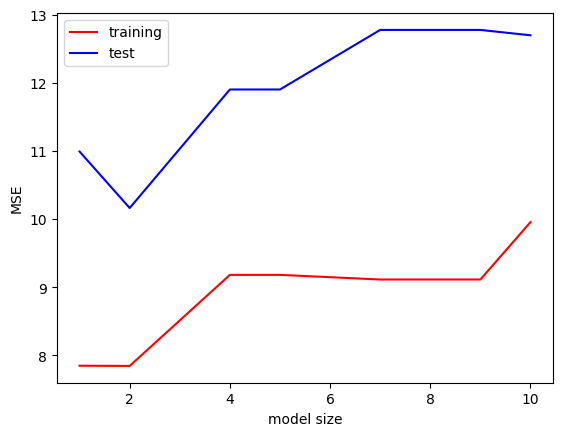

In [299]:
models = [(path[idx]['B'] != 0) for idx in range(len(path))]
MSE = {}

for subset in models:
    X_train_subset = X_train[:, subset][:, 0]
    X_test_subset = X_test[:, subset][:, 0]
    model = OLS(Y_train,
                X_train_subset).fit()
    Y_train_pred = model.predict(X_train_subset)
    Y_test_pred = model.predict(X_test_subset)
    MSE[np.sum(subset)] = [np.mean((Y_train - Y_train_pred)**2),
                           np.mean((Y_test - Y_test_pred)**2)]

fig = plt.figure()
ax = fig.add_subplot()
x = list(MSE.keys())
MSE_train = [MSE_train[1][0] for MSE_train in list(MSE.items())]
MSE_test = [MSE_train[1][1] for MSE_train in list(MSE.items())]
ax.plot(x, MSE_train, c='r', label='training')
ax.plot(x, MSE_test, c='b', label='test')
ax.legend()
ax.set_xlabel('model size')
ax.set_ylabel('MSE')

Seems like MSE explodes after we add more than 1 feature. Lets play around with (a) to see if we can improve it!

Lets first remove the 0 coefficients, and do some more tweaking...

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  1
Iteration: 4. Number of non-zeros:  3
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  3
Iteration: 8. Number of non-zeros:  3
Iteration: 9. Number of non-zeros:  3
Iteration: 10. Number of non-zeros:  6
Iteration: 11. Number of non-zeros:  6
Iteration: 12. Number of non-zeros:  6
Iteration: 13. Number of non-zeros:  6
Iteration: 14. Number of non-zeros:  6
Iteration: 15. Number of non-zeros:  6
Iteration: 16. Number of non-zeros:  6
Iteration: 17. Number of non-zeros:  11
{1: [3791.806057531308, 4097.235724573815], 3: [3774.0069362434206, 4079.0455543211206], 6: [3827.7783581359145, 3994.597341299753], 11: [3827.7783581359145, 3994.597341299753]}


Text(0, 0.5, 'MSE')

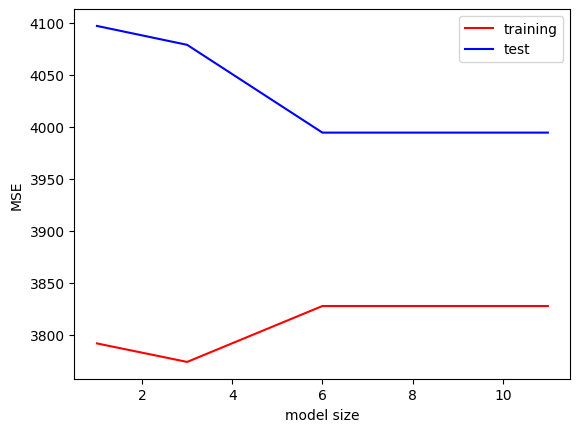

In [273]:
# Generate b vector with logspace
b = np.linspace(-10, 10, 20)
# Generate X matrix
X = np.random.randn(1000, 20)
# Generate eps vector
eps = np.random.randn(1000)
for i in range(0, 20):
    y += b[i] * X[:, i]
y = y + eps

(X_train, X_test,
 Y_train, Y_test) = skm.train_test_split(X, y, test_size=0.9, random_state=0)

path = fit_path(X_train,
                Y_train)

models = [(path[idx]['B'] != 0) for idx in range(len(path))]
MSE = {}
for subset in models:
    X_train_subset = X_train[:, subset][:, 0]
    X_test_subset = X_test[:, subset][:, 0]
    model = OLS(Y_train,
                X_train_subset).fit()
    Y_train_pred = model.predict(X_train_subset)
    Y_test_pred = model.predict(X_test_subset)
    MSE[np.sum(subset)] = [np.mean((Y_train - Y_train_pred)**2),
                           np.mean((Y_test - Y_test_pred)**2)]

fig = plt.figure()
ax = fig.add_subplot()
x = list(MSE.keys())
MSE_train = [MSE_train[1][0] for MSE_train in list(MSE.items())]
MSE_test = [MSE_train[1][1] for MSE_train in list(MSE.items())]
ax.plot(x, MSE_train, c='r', label='training')
ax.plot(x, MSE_test, c='b', label='test')
ax.legend()
ax.set_xlabel('model size')
ax.set_ylabel('MSE')

(f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.

In [312]:
# Generate X matrix
X = np.random.randn(1000, 20)

# Generate b vector with some zeros
b = np.random.randn(20)
b[2] = b[3] = b[8] = b[10] = b[12] = b[13] = b[6] = b[18] = 0

# Generate eps vector
eps = np.random.randn(1000)

# Calculate y
y = np.dot(X, b) + eps

(X_train, X_test,
 Y_train, Y_test) = skm.train_test_split(X, y, test_size=0.9, random_state=0)

path = fit_path(X_train,
                Y_train)

subset = np.where(path[-1]['B'] != 0)
X_train_subset = sm.add_constant(X_train[:, subset][:, 0])
X_test_subset = sm.add_constant(X_test[:, subset][:, 0])
model = OLS(Y_train,
            X_train_subset).fit()
Y_pred = model.predict(X_train_subset)
MSE_training = np.mean((Y_train - Y_pred)**2)
model.summary()

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  3
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  5
Iteration: 7. Number of non-zeros:  5
Iteration: 8. Number of non-zeros:  6
Iteration: 9. Number of non-zeros:  6
Iteration: 10. Number of non-zeros:  6
Iteration: 11. Number of non-zeros:  7
Iteration: 12. Number of non-zeros:  7
Iteration: 13. Number of non-zeros:  7
Iteration: 14. Number of non-zeros:  8
Iteration: 15. Number of non-zeros:  8
Iteration: 16. Number of non-zeros:  8
Iteration: 17. Number of non-zeros:  8
Iteration: 18. Number of non-zeros:  10


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     111.7
Date:                Sat, 09 Sep 2023   Prob (F-statistic):           6.40e-46
Time:                        13:35:54   Log-Likelihood:                -139.45
No. Observations:                 100   AIC:                             300.9
Df Residuals:                      89   BIC:                             329.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1478      0.112     -1.319      0.191      -0.371       0.075
x1            -1.1468      0.121     -9.456      0.000      -1.388      -0.906
x2            -0.4513      0.106     -4.250      0.000      -0.662      -0.240
x3             2.1229      0.118     17.962      0.000       1.888       2.358
x4            -0.5570      0.106     -5.244      0.000      -0.768      -0.346
x5             0.0587      0.109      0.539      0.591      -0.158       0.275
x6            -1.7787      0.104    -17.040      0.000      -1.986      -1.571
x7             0.9715      0.118      8.199      0.000       0.736       1.207
x8             0.7209      0.108      6.661      0.000       0.506       0.936
x9             0.9436      0.115      8.224      0.000       0.716       1.172
x10            1.3144      0.107     12.259      0.000       1.101       1.527
==============================================================================
Omnibus:                        4.524   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                3.964
Skew:                          -0.473   Prob(JB):                        0.138
Kurtosis:                       3.234   Cond. No.                         1.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [313]:
b

array([-1.02467472, -0.05760235,  0.        ,  0.        ,  0.10488324,
       -0.53618489,  0.        ,  2.02876513,  0.        , -0.68744367,
        0.        , -1.60853294,  0.        ,  0.        ,  0.99967227,
        0.70600175,  1.05488524,  1.15360444,  0.        ,  0.01219736])

In [314]:
path[-1]['B']

array([-1.11343021,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.44398602,  0.        ,  2.07468044,  0.        , -0.54860141,
        0.06193961, -1.74206462,  0.        ,  0.        ,  0.96073329,
        0.70517721,  0.92740376,  1.28543218,  0.        ,  0.        ])

As we can see here, coefficients are related.

(g) Create a plot displaying:

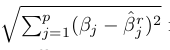

for a range of values of r, where Bjr is the jth coefficient estimate for the best model containing r coefficients. Comment on what you observe. How does this compare to the best MSE plot from (d)?

In [315]:
models = [(path[idx]['B'] != 0) for idx in range(len(path))]
MSE = {}
exercise_formula = {}
for idx, subset in enumerate(models):
    X_train_subset = X_train[:, subset][:, 0]
    X_test_subset = X_test[:, subset][:, 0]
    model = OLS(Y_train,
                X_train_subset).fit()
    Y_train_pred = model.predict(X_train_subset)
    Y_test_pred = model.predict(X_test_subset)
    MSE[np.sum(subset)] = [np.mean((Y_train - Y_train_pred)**2),
                           np.mean((Y_test - Y_test_pred)**2)]
    exercise_formula[np.sum(subset)] = np.sum(np.power(b[subset] - path[idx]['B'][subset], 2))

exercise_formula

{1: 0.017495344905155058,
 2: 0.16770500753992434,
 3: 0.2188578047522638,
 5: 0.18945447622131584,
 6: 0.10721941681564398,
 7: 0.1569487896809074,
 8: 0.12478913494493596,
 10: 0.09457778393193783}

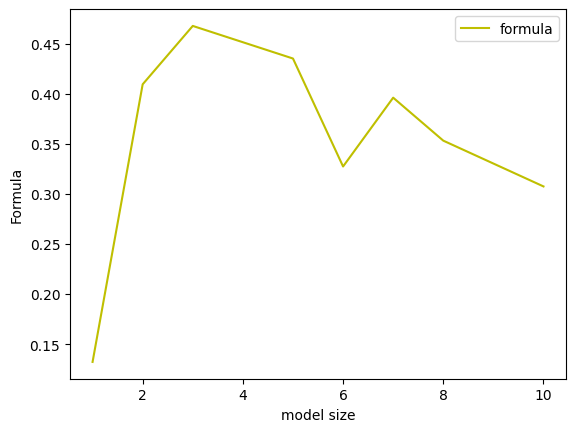

In [316]:
fig = plt.figure()
ax = fig.add_subplot()
x = list(exercise_formula.keys())
y = np.sqrt(list(exercise_formula.values()))
ax.plot(x, y, c='y', label='formula')
ax.set_xlabel('model size')
ax.set_ylabel('Formula')

MSE_test = [MSE_train[1][1] for MSE_train in list(MSE.items())]
# ax.plot(x, MSE_test, c='b', label='test')

ax.legend()

Dissapoingint last 2 exercises. Lets do the last one well!

11. We will now try to predict per capita crime rate in the Boston data set.

    (a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression and PCR. Present and discuss results for the approaches that you consider.

In [427]:
Boston = load_data('Boston')
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [447]:
X = Boston.iloc[:, 1:].to_numpy()
Y = Boston['crim'].to_numpy()

(X_train, X_test,
Y_train, Y_test) = skm.train_test_split(X, Y, test_size=0.2, random_state=0)

(a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.

In [429]:
path = fit_path(X_train,
                Y_train,
                max_nonzeros=X_train.shape[1],
                lambda_2=0)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  10
Iteration: 4. Number of non-zeros:  12


In [430]:
models = [(path[idx]['B'] != 0).tolist() for idx in range(len(path))]
MSE = {}
for model in models:
    print(model)
for subset in models:
    X_train_subset = X_train[:, subset][:, 0]
    X_test_subset = X_test[:, subset][:, 0]
    model = OLS(Y_train,
                X_train_subset).fit()
    Y_pred = model.predict(X_test_subset)
    MSE[np.sum(subset)] = np.mean(np.square(Y_test - Y_pred))
MSE

[False, False, False, False, False, False, False, True, False, False, False, False]
[False, False, False, False, False, False, False, True, False, False, True, False]
[True, False, True, True, True, False, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True, True, True, True]


{1: 67.65557364821309,
 2: 67.65557364821309,
 10: 124.00377012589092,
 12: 124.00377012589092}

In [431]:
pca = PCA()
scaler = StandardScaler()
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])

param_grid = {'pca__n_components': range(X_train.shape[1])}
grid = skm.GridSearchCV(pipe,
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=kfold,
                         verbose=1)

grid.fit(X_train,
         Y_train)

Y_pred = grid.predict(X_test)

mean_squared_error(Y_test, Y_pred)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


62.57841116735953

In [432]:
pls = PLSRegression()
scaler = StandardScaler()
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler),
                 ('pls', pls)])

param_grid = {'pls__n_components': range(X_train.shape[1])}
grid = skm.GridSearchCV(pipe,
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=kfold,
                         verbose=1)

grid.fit(X_train,
         Y_train)

Y_pred = grid.predict(X_test)

mean_squared_error(Y_test, Y_pred)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


60.83323113669461

In [433]:
ridge = skl.ElasticNetCV(l1_ratio=0,
                         alphas=lambdas,
                         random_state=0,
                         cv=kfold)

pipe = Pipeline([('scaler', scaler),
                 ('ridge', ridge)])

pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
mean_squared_error(Y_test, Y_pred)

61.25590327544165

In [434]:
lasso = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipe = Pipeline(steps=[('scaler', scaler),
                       ('lasso', lasso)])
pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
mean_squared_error(Y_test, Y_pred)

60.822187734863476

Even better than PLS! Lasso takes the cake.

(b) For this, lets try every above model but with the subset chosen by fit_path.

In [464]:
(X_train, X_test,
Y_train, Y_test) = skm.train_test_split(X, Y, test_size=0.2, random_state=0)
best_subset = path[2]['B'] != 0
X_train = X_train[:, best_subset]
X_test = X_test[:, best_subset]

In [459]:
pca = PCA()
scaler = StandardScaler()
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])

param_grid = {'pca__n_components': range(X_train.shape[1])}
grid = skm.GridSearchCV(pipe,
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=kfold,
                         verbose=1)

grid.fit(X_train,
         Y_train)

Y_pred = grid.predict(X_test)

mean_squared_error(Y_test, Y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


62.985398991865644

In [460]:
pls = PLSRegression()
scaler = StandardScaler()
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler),
                 ('pls', pls)])

param_grid = {'pls__n_components': range(X_train.shape[1])}
grid = skm.GridSearchCV(pipe,
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=kfold,
                         verbose=1)

grid.fit(X_train,
         Y_train)

Y_pred = grid.predict(X_test)

mean_squared_error(Y_test, Y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


60.20209596544986

In [461]:
ridge = skl.ElasticNetCV(l1_ratio=0,
                         alphas=lambdas,
                         random_state=0,
                         cv=kfold)

pipe = Pipeline([('scaler', scaler),
                 ('ridge', ridge)])

pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
mean_squared_error(Y_test, Y_pred)

60.827502776794645

In [462]:
lasso = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipe = Pipeline(steps=[('scaler', scaler),
                       ('lasso', lasso)])
pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
mean_squared_error(Y_test, Y_pred)

60.504249522230225

They all improved, even Lasso! Lets check which variables are the problematic ones.

In [473]:
pd.DataFrame(Boston).drop(columns='crim').iloc[:, ~best_subset]

,indus,age
0,2.31,65.2
1,7.07,78.9
2,7.07,61.1
3,2.18,45.8
4,2.18,54.2
...,...,...
501,11.93,69.1
502,11.93,76.7
503,11.93,91.0
504,11.93,89.3


(c) Does your chosen model involve all of the features in the data set? Why or why not?

No, I used just 10 variables which seemed to improve the model overall. I chose them using fit_path.